In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
train_path = "/content/PLD_3_Classes_256/Training"
val_path   = "/content/PLD_3_Classes_256/Validation"
test_path  = "/content/PLD_3_Classes_256/Testing"

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Classes: ['Early_Blight', 'Healthy', 'Late_Blight']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [5]:
base_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_resnet.trainable = False     # Freeze to train fast

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

resnet_model = Model(inputs=base_resnet.input, outputs=output)

In [7]:
resnet_model.compile(
    optimizer=Adam(0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [8]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12
)

Epoch 1/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.7650 - loss: 0.5824 - val_accuracy: 0.8918 - val_loss: 0.2604
Epoch 2/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.9176 - loss: 0.2187 - val_accuracy: 0.9423 - val_loss: 0.1435
Epoch 3/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 595s 6s/step - accuracy: 0.9337 - loss: 0.1771 - val_accuracy: 0.9423 - val_loss: 0.1288
Epoch 4/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 575s 6s/step - accuracy: 0.9400 - loss: 0.1534 - val_accuracy: 0.9231 - val_loss: 0.1803
Epoch 5/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 640s 6s/step - accuracy: 0.9465 - loss: 0.1364 - val_accuracy: 0.9591 - val_loss: 0.1098
Epoch 6/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.9615 - loss: 0.1069 - val_accuracy: 0.9279 - val_loss: 0.1526
Epoch 7/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.9575 - loss: 0.1168 - val_accuracy: 0.9471 - val_loss: 0.1057
Epoch 8/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 637s 6s/step - accuracy: 0.9661 - loss: 0.0952 - val_accu

KeyboardInterrupt: 

In [9]:
test_loss, test_acc = resnet_model.evaluate(test_ds)
print("Test Accuracy:", round(test_acc, 4))
print("Test Loss:", round(test_loss, 4))

13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.9647 - loss: 0.1178
Test Accuracy: 0.9679
Test Loss: 0.0942


In [11]:
# ----- TRUE LABELS -----
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# ----- PREDICTED LABELS -----
y_pred_probs = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# ----- CLASSES -----
print("Classes:", class_names)

13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step
Classes: ['Early_Blight', 'Healthy', 'Late_Blight']


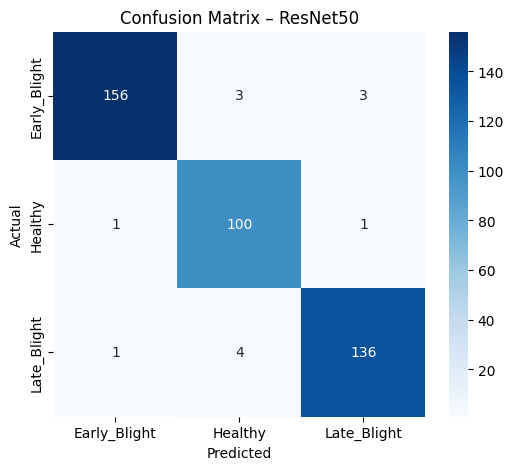

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – ResNet50")
plt.show()

In [13]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

              precision    recall  f1-score   support

Early_Blight       0.99      0.96      0.97       162
     Healthy       0.93      0.98      0.96       102
 Late_Blight       0.97      0.96      0.97       141

    accuracy                           0.97       405
   macro avg       0.96      0.97      0.97       405
weighted avg       0.97      0.97      0.97       405



In [14]:
resnet_model.save("FA2_Model2_ResNet50.h5")
print("Model saved as FA2_Model2_ResNet50.h5")

Model saved as FA2_Model2_ResNet50.h5


In [18]:
history_resnet = resnet_model.history

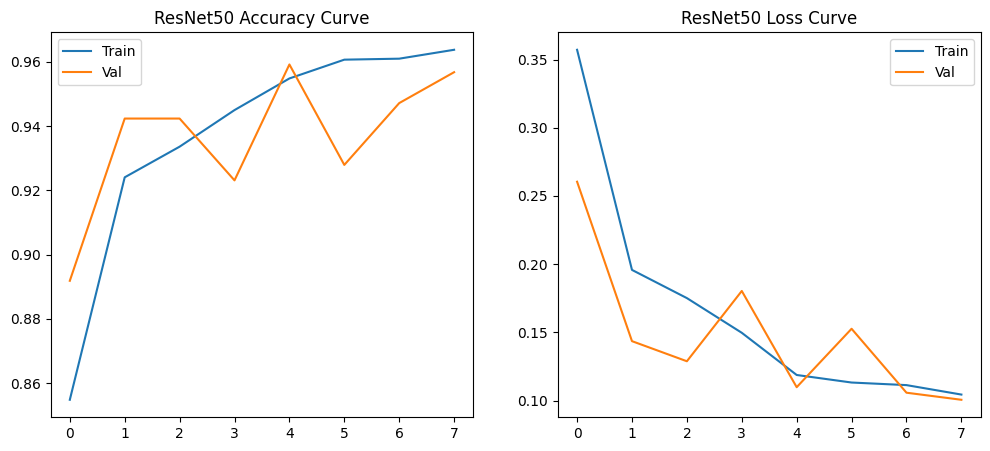

In [21]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title("ResNet50 Accuracy Curve")
plt.legend(["Train", "Val"])

# Loss
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title("ResNet50 Loss Curve")
plt.legend(["Train", "Val"])

plt.show()

In [22]:
import pandas as pd

df = pd.DataFrame({
    "True_Label": y_true,
    "Predicted_Label": y_pred
})

df.to_csv("ResNet50_Test_Predictions.csv", index=False)
print("Saved predictions CSV.")

Saved predictions CSV.
